# NoteBook para análisis exploratorio de los datos.
## Se busca hallar conclusiones que nos ayude con el preprocesamiento.

Tras tratar un poco con los datos, se ha llegado a la conclusión de que, una mejor exploración previa de los datos, va a ayudar a comprender de una manera más profunda que variables son importantes, como tratar con ellas y ver que modificaciones/eliminaciones se pueden hacer para tratar de mejorar el rendimiento de nuestros modelos.

In [4]:
#Celda para librerías


import sklearn as sk

import matplotlib as plt
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings('ignore')

print(np.__version__)
from ydata_profiling import ProfileReport
import os
print("Directorio actual:", os.getcwd())



# Have all columns appear when dataframes are displayed.
pd.set_option('display.max_columns', None) 
# Have 100 rows appear when a dataframe is displayed
pd.set_option('display.max_rows', 500)
# Display dimensions whenever a dataframe is printed out.
pd.set_option('display.show_dimensions', True)

1.23.5
Directorio actual: c:\Users\Yeray\Desktop\DATA_SCIENCE_ML\Home-Credit-TFG\JUPYTER_NOTEBOOKS


In [2]:
#Importando los datos

app_train = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/application_test.csv')

bureau = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/bureau_balance.csv')
credit_card_balance = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/credit_card_balance.csv')
installments_payments = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/installments_payments.csv')
pos_cash_balance = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/POS_CASH_balance.csv')
previous_application = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/previous_application.csv')


info = app_train.info()
print(info)
describe = app_train.describe()
print(describe)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.

# Data Exploration of Application_train.csv

In [ ]:
#Vamos a generar un report mínimo de los datos sin tratar para ver si hay algo que nos llame la atención
report_raw = ProfileReport(app_train, minimal=True)
display(report_raw)
report_raw.to_file("report_raw.html")

In [5]:

#Tras ver el report observamos que nuestra columna TARGET está desbalanceada, vamos a ver cuantos valores hay de cada tipo
print(app_train['TARGET'].value_counts())

#Vamos a dividir el dataset en TARGET=1 y TARGET=0 para ver si hay alguna diferencia en las variables
app_train_1 = app_train[app_train['TARGET']==1]
app_train_0 = app_train[app_train['TARGET']==0]

#Vamos a pasar la edad de días a años
app_train['AGE_INT'] = (app_train['DAYS_BIRTH'] / -365).astype(int)



#Vamos a crear una gráfica violín para ver correlaciones entre variables y TARGET
violin_TARGET_1 = go.Violin(
    y=app_train_1['AGE_INT'],
    x=app_train_1['TARGET'],
    name='IMPAGOS',
    marker_color = 'red',
    box_visible=True,
)

violin_TARGET_0 = go.Violin(
    y=app_train_0['AGE_INT'],
    x=app_train_0['TARGET'],
    name='NO IMPAGOS',
    marker_color = 'blue',
    box_visible=True,
)

data = [violin_TARGET_1, violin_TARGET_0]

layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title='Distribución de la edad en función de TARGET',
    xaxis=dict(
        title='Impagos o no'
    ),
    yaxis=dict(
        title='Age'
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

TARGET
0    282686
1     24825
Name: count, Length: 2, dtype: int64


## Podemos observas que los pagos están balanceado, pero que, por otro lado, los impagos se suelen concentrar más en un rango de edad de entre 27 y 38 años.

Se podría considerar agrupar esta variable en un intervalo (binning) de cara a simplificar el modelo.

## De cara a los valores nulos, previos a tratarlos, vamos a comprobar varias cosas:
Primero, declarar que los valores nulos se entienden como valores que no han sido registrados/perdidos/no fueron proporcionados.

Dicho esto, con esta exploración se quieren averiguar varias cuestiones:

1. Estos valores nulos presentar alguna especie de patrón de tal manera de que la presencia/ausencia de estos conlleve a un impago.

2. Comprobar si la existencia de valores nulos en ciertas variables puede conllevar a la detección de un impago. Por ejemplo, si tenemos una columna cuyos pocos valores nulos están altamente correlacionados con un impago, podemos determinar la importancia de la misma.

3. Por último, ver si la mayoría de estos valores nulos perteneces a variables numéricas mayoritariamente, categóricas o a una combinación de ambas.

In [8]:
#Comprobamos la cantidad de valores nulos que tenemos en cada columnas
variables_ordenadas_por_valores_nulos = app_train.isnull().sum().sort_values(ascending=False)

#Queremos ver solo aquellas columnas que tengan valores nulos
col_nulos = variables_ordenadas_por_valores_nulos[variables_ordenadas_por_valores_nulos > 0]

#Vamos a crear un data set con las columnas que tienen valores nulos e información sobre los mismos
app_train_nulos = pd.DataFrame(index= col_nulos.index , columns=['Nº de Nulos', 'Porcentaje de nulos', 'Nº de nulos que son impagos'
                                                   , 'Porcentaje de nulos que son impagos', 'Nº de no nulos',
                                                   'Porcentaje de no nulos', 'Nº de no nulos con impagos'
                                                   ,'Porcentaje de no nulos con impagos'])

for variable in app_train_nulos.index:
    #Nº de nulos
    nulos = col_nulos.loc[variable]
    app_train_nulos['Nº de Nulos'][variable] = nulos
    #Nº de no nulos
    numero_de_entradas=app_train[variable].shape[0]
    no_nulos = numero_de_entradas - nulos
    app_train_nulos['Nº de no nulos'][variable] = no_nulos
    #Porcentaje de nulos
    porcentaje_nulos = round((nulos / (nulos + no_nulos)), 4)
    app_train_nulos['Porcentaje de nulos'][variable] = porcentaje_nulos
    #Porcentaje de no nulos
    porcentaje_no_nulos = round((no_nulos / (nulos + no_nulos)), 4)
    app_train_nulos['Porcentaje de no nulos'][variable] = porcentaje_no_nulos
    #Nº de nulos que son impagos	
    nulos_impagos = app_train[app_train[variable].isnull()]['TARGET'].sum()
    app_train_nulos['Nº de nulos que son impagos'][variable] = nulos_impagos
    #Porcentaje de nulos que son impagos
    porcentaje_nulos_impagos = round((nulos_impagos / nulos), 4)
    app_train_nulos['Porcentaje de nulos que son impagos'][variable] = porcentaje_nulos_impagos
    #Nº de no nulos con impagos
    no_nulos_impagos = app_train[app_train[variable].notnull()]['TARGET'].sum()
    app_train_nulos['Nº de no nulos con impagos'][variable] = no_nulos_impagos
    #Porcentaje de no nulos con impagos
    porcentaje_no_nulos_impagos = round((no_nulos_impagos / no_nulos), 4)
    app_train_nulos['Porcentaje de no nulos con impagos'][variable] = porcentaje_no_nulos_impagos

#Vamos a ver el dataset con la información de los valores nulos
display(app_train_nulos, 'display')


Nº de Nulos Porcentaje de nulos  \
COMMONAREA_MEDI                   214865              0.6987   
COMMONAREA_AVG                    214865              0.6987   
COMMONAREA_MODE                   214865              0.6987   
NONLIVINGAPARTMENTS_MODE          213514              0.6943   
NONLIVINGAPARTMENTS_AVG           213514              0.6943   
NONLIVINGAPARTMENTS_MEDI          213514              0.6943   
FONDKAPREMONT_MODE                210295              0.6839   
LIVINGAPARTMENTS_MODE             210199              0.6835   
LIVINGAPARTMENTS_AVG              210199              0.6835   
LIVINGAPARTMENTS_MEDI             210199              0.6835   
FLOORSMIN_AVG                     208642              0.6785   
FLOORSMIN_MODE                    208642              0.6785   
FLOORSMIN_MEDI                    208642              0.6785   
YEARS_BUILD_MEDI                  204488               0.665   
YEARS_BUILD_MODE                  204488               0.665   
YEARS_BUILD_AVG                   204488               0.665   
OWN_CAR_AGE                       202929              0.6599   
LANDAREA_MEDI                     182590              0.5938   
LANDAREA_MODE                     182590              0.5938   
LANDAREA_AVG                      182590              0.5938   
BASEMENTAREA_MEDI                 179943              0.5852   
BASEMENTAREA_AVG                  179943              0.5852   
BASEMENTAREA_MODE                 179943              0.5852   
EXT_SOURCE_1                      173378              0.5638   
NONLIVINGAREA_MODE                169682              0.5518   
NONLIVINGAREA_AVG                 169682              0.5518   
NONLIVINGAREA_MEDI                169682              0.5518   
ELEVATORS_MEDI                    163891               0.533   
ELEVATORS_AVG                     163891               0.533   
ELEVATORS_MODE                    163891               0.533   
WALLSMATERIAL_MODE                156341              0.5084   
APARTMENTS_MEDI                   156061              0.5075   
APARTMENTS_AVG                    156061              0.5075   
APARTMENTS_MODE                   156061              0.5075   
ENTRANCES_MEDI                    154828              0.5035   
ENTRANCES_AVG                     154828              0.5035   
ENTRANCES_MODE                    154828              0.5035   
LIVINGAREA_AVG                    154350              0.5019   
LIVINGAREA_MODE                   154350              0.5019   
LIVINGAREA_MEDI                   154350              0.5019   
HOUSETYPE_MODE                    154297              0.5018   
FLOORSMAX_MODE                    153020              0.4976   
FLOORSMAX_MEDI                    153020              0.4976   
FLOORSMAX_AVG                     153020              0.4976   
YEARS_BEGINEXPLUATATION_MODE      150007              0.4878   
YEARS_BEGINEXPLUATATION_MEDI      150007              0.4878   
YEARS_BEGINEXPLUATATION_AVG       150007              0.4878   
TOTALAREA_MODE                    148431              0.4827   
EMERGENCYSTATE_MODE               145755               0.474   
OCCUPATION_TYPE                    96391              0.3135   
EXT_SOURCE_3                       60965              0.1983   
AMT_REQ_CREDIT_BUREAU_HOUR         41519               0.135   
AMT_REQ_CREDIT_BUREAU_DAY          41519               0.135   
AMT_REQ_CREDIT_BUREAU_WEEK         41519               0.135   
AMT_REQ_CREDIT_BUREAU_MON          41519               0.135   
AMT_REQ_CREDIT_BUREAU_QRT          41519               0.135   
AMT_REQ_CREDIT_BUREAU_YEAR         41519               0.135   
NAME_TYPE_SUITE                     1292              0.0042   
OBS_30_CNT_SOCIAL_CIRCLE            1021              0.0033   
DEF_30_CNT_SOCIAL_CIRCLE            1021              0.0033   
OBS_60_CNT_SOCIAL_CIRCLE            1021              0.0033   
DEF_60_CNT_SOCIAL_CIRCLE            1021              0.0033 

'display'

## Conclusiones

#Primera cuestión
Respecto al hecho de apreciar si existe algún patrón que nos indique que la presencia de nulos signifique un claro impago, no podemos llegar a ninguna conclusión contundente. Si bien es cierto que alguna variable tiene un porcentaje de nulos con impago minimamente representativo, al fijarse en la diferencia respecto al porcentaje de impagos con no nulos, no se aprecia una diferencia estadisticamente notoria.

#Segunda cuestión

Es importante recordar primero que el número de impagos es de 24825. Dicho esto, si una variable tiene muchos valores nulos, los impagos pueden no estar bien representados en los datos válidos de la misma. 

Por ejemplo, COMMONAREA_EDI, tiene más del 66% de valores nulos, por lo que no se podrían determinar bien la 
correlacion entre datos válidos e impagos si nos ceñimos a los valores nulos. 

Entonces, ¿se puede determinar un umbral para determinar si una columna ha de ser eliminada al tener muchos nulos? Por ahora, dependería de esta distribución de los datos válidos y del algoritmo que se use, pero de momento, no eliminar ninguna columna aunque solo tenga un 30% de datos válidos parece ser lo más correcto.

#Tercera cuestión

Se puede observar como los valores nulos están mucho más presentes en las columnas numéricas que en las categóricas, incluso en aquellas ya codificadas en one-hot como FLAG_DOCUMENT... donde ni siquiera hay valores nulos.

In [8]:
#Vamos a ver la cantidad de valores nulos para cada persona que tiene impagos
impagos_ordenados_por_valores_nulos = app_train_1.isnull().sum(axis=1).sort_values(ascending=False)
display(impagos_ordenados_por_valores_nulos)


172595    60
249616    59
299853    59
74199     59
3525      58
          ..
162471     0
302226     0
70524      0
126086     0
159662     0
Length: 24825, dtype: int64

Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=105)
SK_ID_CURR: Min = 100002, Max = 456255
CNT_CHILDREN: Min = 0, Max = 19
AMT_INCOME_TOTAL: Min = 25650.0, Max = 117000000.0
AMT_CREDIT: Min = 45000.0, Max = 4050000.0
AMT_ANNUITY: Min = 1615.5, Max = 258025.5
AMT_GOODS_PRICE: Min = 40500.0, Max = 4050000.0
REGION_POPULATION_RELATIVE: Min = 0.00029, Max = 0.072508
DAYS_BIRTH: Min = -25229, Max = -7489
DAYS_EMPLOYED: Min = -17912, Max = 365243
DAYS_REGISTRATION: Min = -24672.0, Max = 0.0
DAYS_ID_PUBLISH: Min = 

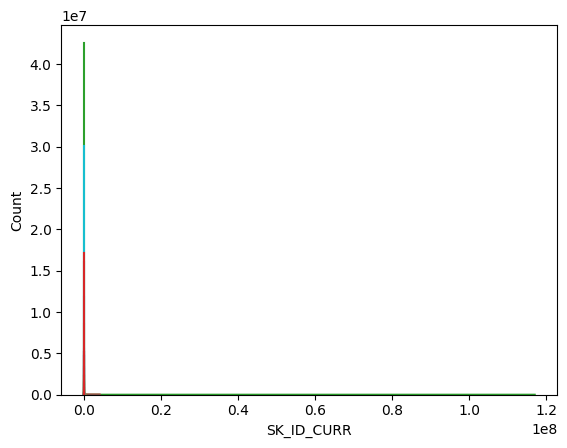

In [10]:
#Vamos a explorar las variables numéricas y categóricas
#Vamos a ver las variables numéricas
variables_numericas = app_train.select_dtypes(include=['int64', 'float64']).columns
variables_numericas = variables_numericas.drop('TARGET')
print(variables_numericas)

#¿Que variables están "skewed"?
for col in variables_numericas:
    print(f"{col}: Min = {app_train[col].min()}, Max = {app_train[col].max()}")
    sns.histplot(app_train[col], kde=True)
    # plt.show()

for col in variables_numericas:
    mean = app_train[col].mean()
    std = app_train[col].std()
    print(f"{col}: Mean = {mean:.2f}, Std Dev = {std:.2f}")




In [11]:
#Vamos a ver las variables que se encuentran en el rango [0,1]
for col in variables_numericas:
    if app_train[col].min()>=0 and app_train[col].max()<=1:
        print("Variables que están en el rango [0,1]:", col)

Variables que están en el rango [0,1]: REGION_POPULATION_RELATIVE
Variables que están en el rango [0,1]: FLAG_MOBIL
Variables que están en el rango [0,1]: FLAG_EMP_PHONE
Variables que están en el rango [0,1]: FLAG_WORK_PHONE
Variables que están en el rango [0,1]: FLAG_CONT_MOBILE
Variables que están en el rango [0,1]: FLAG_PHONE
Variables que están en el rango [0,1]: FLAG_EMAIL
Variables que están en el rango [0,1]: REG_REGION_NOT_LIVE_REGION
Variables que están en el rango [0,1]: REG_REGION_NOT_WORK_REGION
Variables que están en el rango [0,1]: LIVE_REGION_NOT_WORK_REGION
Variables que están en el rango [0,1]: REG_CITY_NOT_LIVE_CITY
Variables que están en el rango [0,1]: REG_CITY_NOT_WORK_CITY
Variables que están en el rango [0,1]: LIVE_CITY_NOT_WORK_CITY
Variables que están en el rango [0,1]: EXT_SOURCE_1
Variables que están en el rango [0,1]: EXT_SOURCE_2
Variables que están en el rango [0,1]: EXT_SOURCE_3
Variables que están en el rango [0,1]: APARTMENTS_AVG
Variables que están en 

### Variables atípicas

Tras mostrar las variables mediante un histograma nos podemos percatar de varias cosas.

-La variable DAYS_EMPLOYEED tiene valores atípicos. Este tipo de variables contiene valores negativos que indican el número de días desde que pasó lo que indica la variable. En este caso tenemos un valor que índica que una persona tiene el valor 365243 como valor positivo. Esto se traduce en unos 1000 años lo cual de por sí es imposible, sumado al hecho de que los valores han de ser negativos.

-Por otro lado, la variable CNT_CHILDREN indica cuántos hijos tiene cada persona. La mayoría de ellos no tienen hijos, siendo la el máximo valor 19 hijos. Podría considerarse cambiar esta variable a otra que indique si se tiene hijos o no directamente, pues al no tener la mayoría no debería de afectar de manera negativa, incluso pudiendo mejorar un poco.

Conforme a la información obtenida con los valores máximos, mínimos, media y derivación estandar, podemos deducir que variables están normalizadas o en su defecto lo necesitan. Los criterios que se han seguido para sacar conclusiones son:

1. Rango amplio: Si el rango (Max − Min) es significativamente grande en comparación con otras variables, podría ser necesaria la normalización.
2. Desbalance entre media y rango: Si la media no está centrada dentro del rango o parece muy pequeña comparada con el máximo, puede ser un indicador.
3. Distribución inherentemente normalizada: Variables ya en el rango [0, 1] o que parecen estar escaladas (como algunas con "AVG", "MEDI", "MODE") no necesitan normalización.

Teniendo esto en cuenta:

-Variables que posiblemente necesiten normalización:

*AMT_CREDIT: Min = 45000.0, Max = 4050000.0, Mean = 599,026.00. El rango es muy amplio ~4000000. Requiere normalización.
*AMT_INCOME_TOTAL: Min = 25650.0, Max = 117000000.0, Mean = 168,797.92. El rango vuelve a ser muy amplio, requiere de normalización.
*AMT_ANNUITY: Min = 1615.5, Max = 258025.5, Mean = 27,108.57. El rango vuelve a ser muy amplio, requiere de normalización.
*AMT_GOODS_PRICE: Min = 40500.0, Max = 4050000.0, Mean = 538,396.21. El rango vuelve a ser muy amplio requiere de normalización.

*DAYS_EMPLOYED: Min = -17912, Max = 365243, Mean = 63815.05. En este caso puede que no sea necesaria normalización como tal pero si habría que tratar con esos valores sin sentido en caso de que afecten al modelo. Podría considerarse cambiarse por una variable nueva o hacer algún tipo de imputación de valores.
*DAYS_REGISTRATION: Min = -24672.0, Max = 0.0, Mean = -4,986.12. Podría considerarse normalización, pero no es tan destacado como las otras variables.

*CNT_CHILDREN: Min = 0, Max = 19, Mean = 0.42. A primera vista podría no ser demasiada diferencia de rango, pero si lo comparamos con el valor medio sumado al hecho de que la mayoría de personas no tienen hijos, deberiamos de considerar ajustarla de alguna manera como por ejemplo creando una nueva variable que nos indique directamente si tiene o no tiene hijos.

-Otros casos podrían considerarse adecuados para la normalización, como son las siguiente variables, pero no considero que sean casos tan "extremos" como para las anteriores. Igualmente si nos fijamos en su derivación estandar podemos ver que en algunos casos la mayoría de valores se encuentra acorde a la media, por lo que es cierto que existen valores atípicos que habría que tener en cuenta al menos.

*AMT_REQ_CREDIT_BUREAU_DAY: Min = 0.0, Max = 9.0, Mean = 0.01, Std Dev = 0.08
*AMT_REQ_CREDIT_BUREAU_WEEK: Min = 0.0, Max = 8.0, Mean = 0.01, Std Dev = 0.11
*AMT_REQ_CREDIT_BUREAU_MON: Min = 0.0, Max = 27.0, Mean = 0.27, Std Dev = 0.92
*AMT_REQ_CREDIT_BUREAU_QRT: Min = 0.0, Max = 261.0, Mean = 0.27, Std Dev = 0.79
*AMT_REQ_CREDIT_BUREAU_YEAR: Min = 0.0, Max = 25.0, Mean = 1.90, Std Dev = 1.87

*OBS_30_CNT_SOCIAL_CIRCLE: Min = 0.0, Max = 348.0, Mean = 1.42, Std Dev = 2.40
*DEF_30_CNT_SOCIAL_CIRCLE: Min = 0.0, Max = 34.0, Mean = 0.14, Std Dev = 0.45
*OBS_60_CNT_SOCIAL_CIRCLE: Min = 0.0, Max = 344.0, Mean = 1.41, Std Dev = 2.38
*DEF_60_CNT_SOCIAL_CIRCLE: Min = 0.0, Max = 24.0, Mean = 0.10, Std Dev = 0.36


-Respecto al resto de variables, muchas de ellas no necesitan normalización porque se encuentran en el rango [0,1] como pueden ser:
 
*Para ver cuáles son las variables que cumplen esta característica ver output de la celda de código superior a esta.*

In [8]:
#Vamos a ver las variables categóricas
variables_categoricas= app_train.select_dtypes(include='object').columns
#Variables numéricas para ver cuales son binarias
columnas_binarias=app_train.select_dtypes(include=['int64', 'float64']).columns.drop('TARGET')
print("Variables categóricas que deberán de ser one-hot encoded (o similar) en caso de que sea" 
      "necesario dependiendo del modelo",variables_categoricas)

#Vamos a ver la cantidad de valores únicos que tienen las variables categóricas
for col in variables_categoricas:
    if not pd.api.types.is_numeric_dtype(app_train[col]):
        print(f"Valores único en la columna {col}:")
        print(app_train[col].unique())

#Que variables "posiblemente" ya están codificadas.
col_binarias = [col for col in columnas_binarias if app_train[col].nunique() == 2]
print("Columnas que ya estén posiblemente con codificación one-hot", col_binarias, "\n" ,len(col_binarias))


Variables categóricas que deberán de ser one-hot encoded (o similar) en caso de que seanecesario dependiendo del modelo Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')
Valores único en la columna NAME_CONTRACT_TYPE:
['Cash loans' 'Revolving loans']
Valores único en la columna CODE_GENDER:
['M' 'F' 'XNA']
Valores único en la columna FLAG_OWN_CAR:
['N' 'Y']
Valores único en la columna FLAG_OWN_REALTY:
['Y' 'N']
Valores único en la columna NAME_TYPE_SUITE:
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
Valores único en la columna NAME_INCOME_TYPE:
['Working' 'State servant' 'Commercial associate' 'Pens